Objective: To identify the most significant environmental and temporal factors that influence household appliance energy consumption, and to use these factors to develop an accurate and interpretable machine learning model for energy usage prediction.

First step: Clean the dataset and display a clean version

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score

file_path = "KAG_energydata_complete.csv"
df = pd.read_csv(file_path)
df.head()
df.shape






(19735, 29)

In [58]:
# Extract time-based features
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

# Drop the original date column
df.drop(columns=['date'], inplace=True)

In [59]:
# Separate features and target variable
X = df.drop(columns=['Appliances'])
y = df['Appliances']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

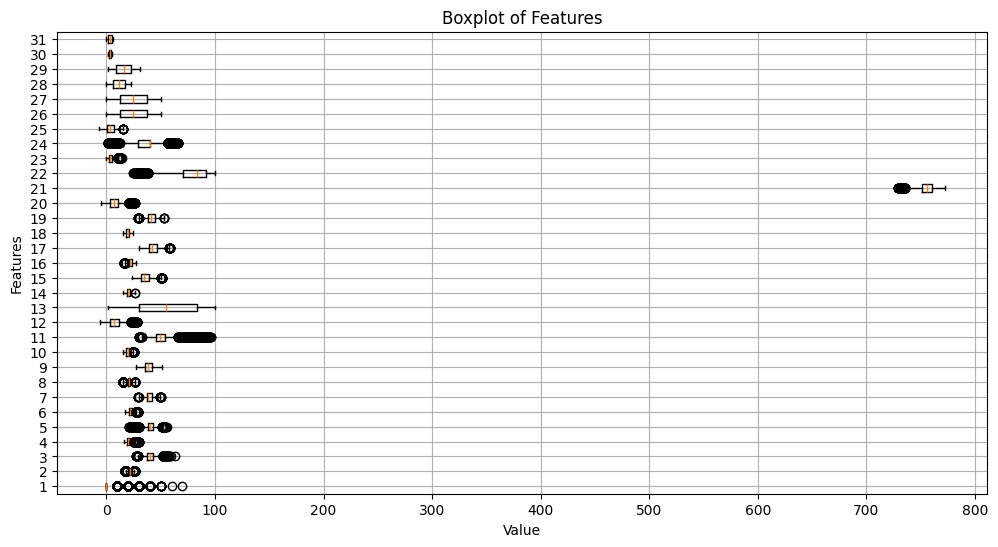

In [14]:
#Boxplot the features
plt.figure(figsize=(12, 6))
plt.boxplot(X, vert=False)
plt.title('Boxplot of Features')
plt.xlabel('Value')
plt.ylabel('Features')
plt.grid()
plt.show()


We can see a high volatilty on several features. Therefore, let's standardize the data to avoid these extreme values to influence our analysis.

In [22]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save feature names
feature_names = X.columns.tolist()

print(df.head(10))

   Appliances  lights         T1       RH_1     T2       RH_2     T3  \
0          60      30  19.890000  47.596667  19.20  44.790000  19.79   
1          60      30  19.890000  46.693333  19.20  44.722500  19.79   
2          50      30  19.890000  46.300000  19.20  44.626667  19.79   
3          50      40  19.890000  46.066667  19.20  44.590000  19.79   
4          60      40  19.890000  46.333333  19.20  44.530000  19.79   
5          50      40  19.890000  46.026667  19.20  44.500000  19.79   
6          60      50  19.890000  45.766667  19.20  44.500000  19.79   
7          60      50  19.856667  45.560000  19.20  44.500000  19.73   
8          60      40  19.790000  45.597500  19.20  44.433333  19.73   
9          70      40  19.856667  46.090000  19.23  44.400000  19.79   

        RH_3         T4       RH_4  ...     RH_out  Windspeed  Visibility  \
0  44.730000  19.000000  45.566667  ...  92.000000   7.000000   63.000000   
1  44.790000  19.000000  45.992500  ...  92.000000   

Next step: Create a Correlation matrix to understand the relationship between features in the dataset. 

This will help us answer the question of which environmental and time-based features have the most impact on appliance energy usage.

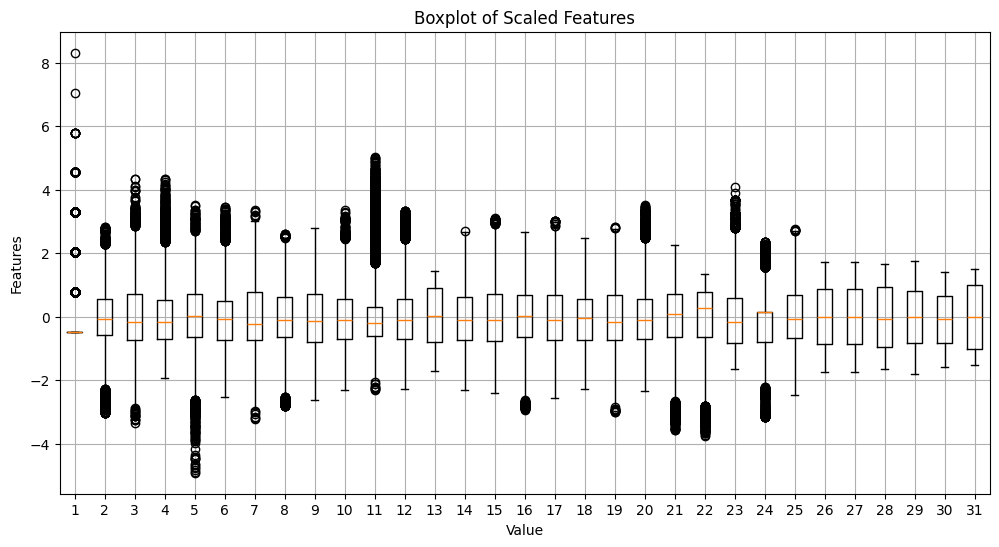

In [16]:
#Boxplot the scaled features
plt.figure(figsize=(12, 6))
plt.boxplot(X_train_scaled)
plt.title('Boxplot of Scaled Features')
plt.xlabel('Value')
plt.ylabel('Features')
plt.grid()
plt.show()


In [23]:
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['Appliances'].sort_values(ascending=False)

print("Top 10 features correlated with Appliances:")
print(correlation_with_target[1:11])

Top 10 features correlated with Appliances:
hour         0.216792
lights       0.197278
T2           0.120073
T6           0.117638
T_out        0.099155
Windspeed    0.087122
RH_1         0.086031
T3           0.085060
T1           0.055447
T4           0.040281
Name: Appliances, dtype: float64


To make it more visual we will create a plot of this data.

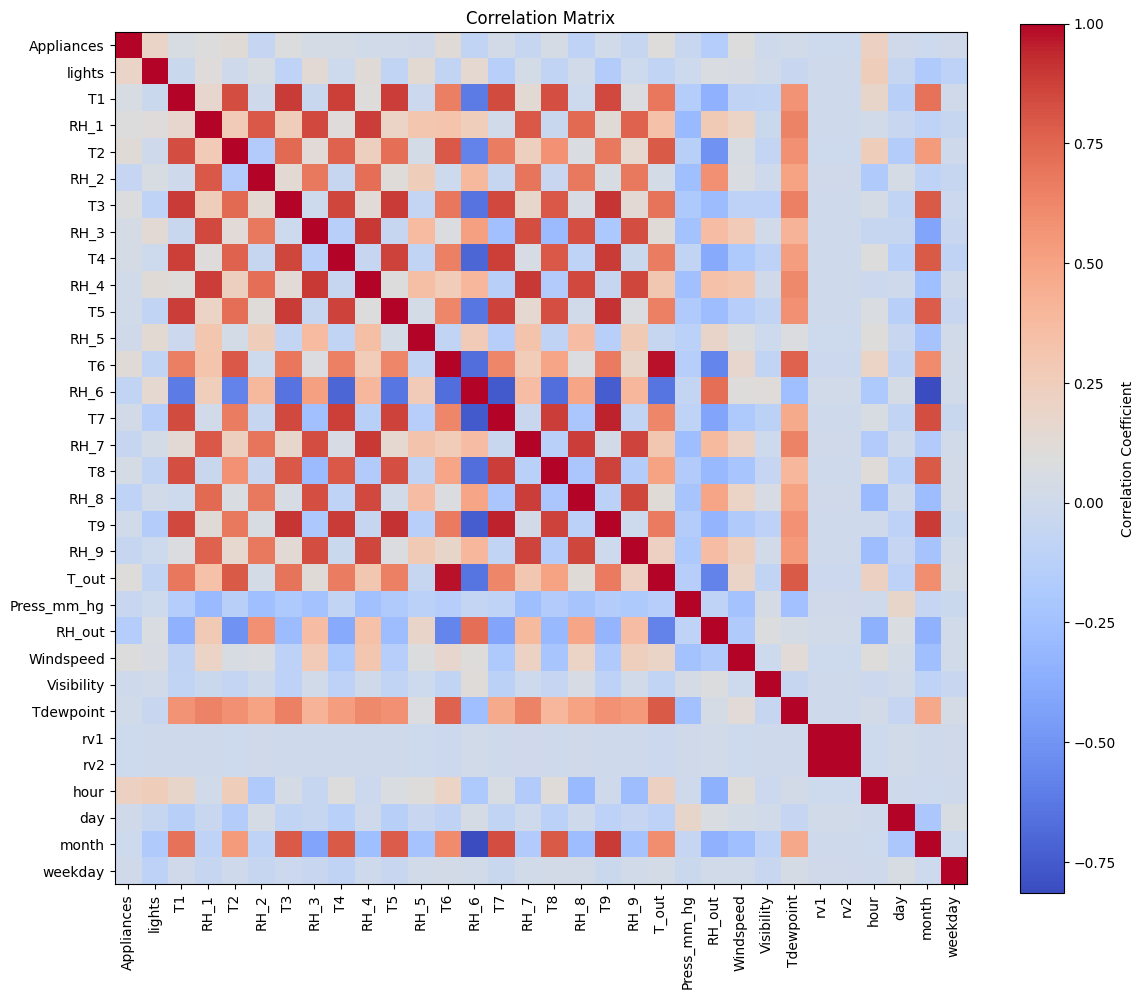

In [7]:
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')

tick_marks = np.arange(len(correlation_matrix.columns))
plt.xticks(tick_marks, correlation_matrix.columns, rotation=90)
plt.yticks(tick_marks, correlation_matrix.columns)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

To check how features affect model performance we will perform a Permutation Feature Importance test on the Random Forrest model

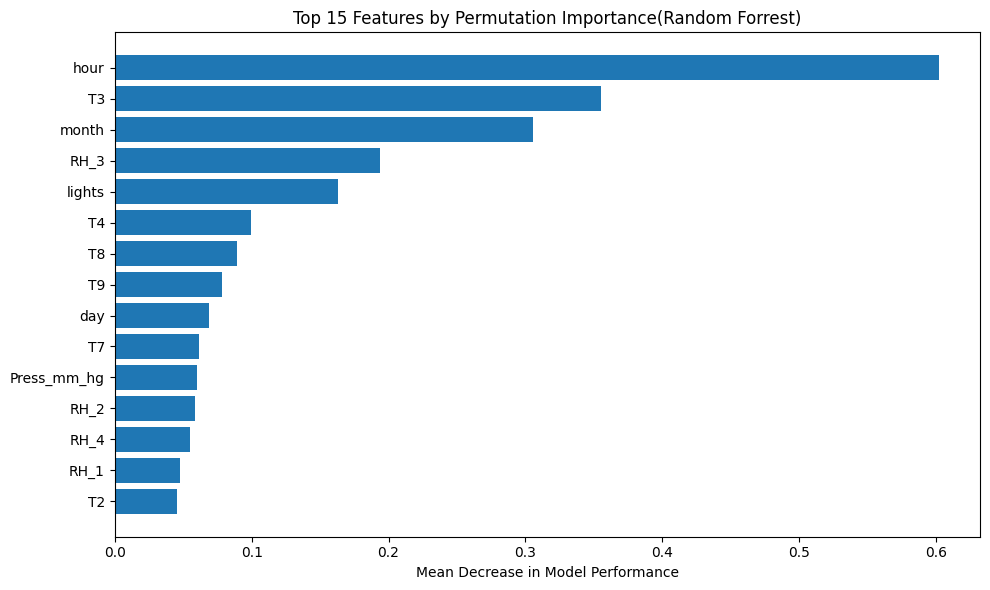

In [8]:
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train_scaled, y_train)

result = permutation_importance(rf_model, X_test_scaled, y_test, n_repeats=5, random_state=42, n_jobs=-1)
rf_importances = result.importances_mean
indices = np.argsort(rf_importances)[::-1]
features = X.columns[indices]

plt.figure(figsize=(10, 6))
plt.barh(range(15), rf_importances[indices][:15], align='center')
plt.yticks(range(15), features[:15])
plt.xlabel("Mean Decrease in Model Performance")
plt.title("Top 15 Features by Permutation Importance(Random Forrest)")
plt.gca().invert_yaxis()  # Most important at the top
plt.tight_layout()
plt.show()

Next step is to do the same on the linear regression model.

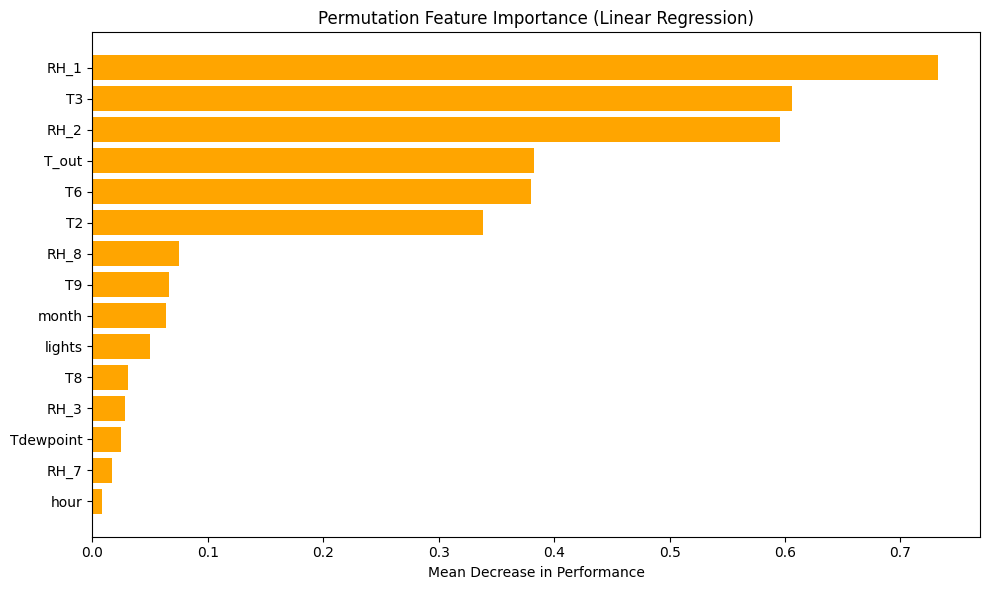

In [10]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

perm_result = permutation_importance(
    lr_model, X_test_scaled, y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

lr_importances = perm_result.importances_mean
indices = np.argsort(lr_importances)[::-1]
feature_names = X.columns[indices]

top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), lr_importances[indices[:top_n]], color='orange')
plt.yticks(range(top_n), feature_names[:top_n])
plt.xlabel("Mean Decrease in Performance")
plt.title("Permutation Feature Importance (Linear Regression)")
plt.gca().invert_yaxis()  # Most important feature at the top
plt.tight_layout()
plt.show()

Finally we will check Permutation Feature Importance on the last model Gradient Boosting

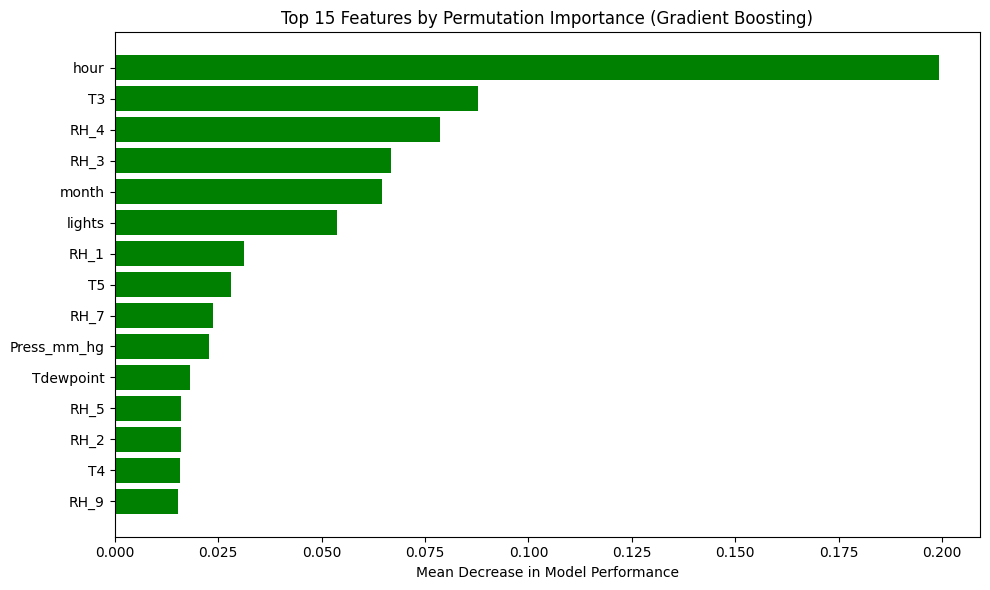

In [11]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

gb_result = permutation_importance(gb_model, X_test_scaled, y_test, n_repeats=5, random_state=42, n_jobs=-1)
gb_importances = gb_result.importances_mean
gb_indices = np.argsort(gb_importances)[::-1]
gb_features = X.columns[gb_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(15), gb_importances[gb_indices][:15], align='center', color='green')
plt.yticks(range(15), gb_features[:15])
plt.xlabel("Mean Decrease in Model Performance")
plt.title("Top 15 Features by Permutation Importance (Gradient Boosting)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Let's provide one last regression algorithm : Support vector regressor

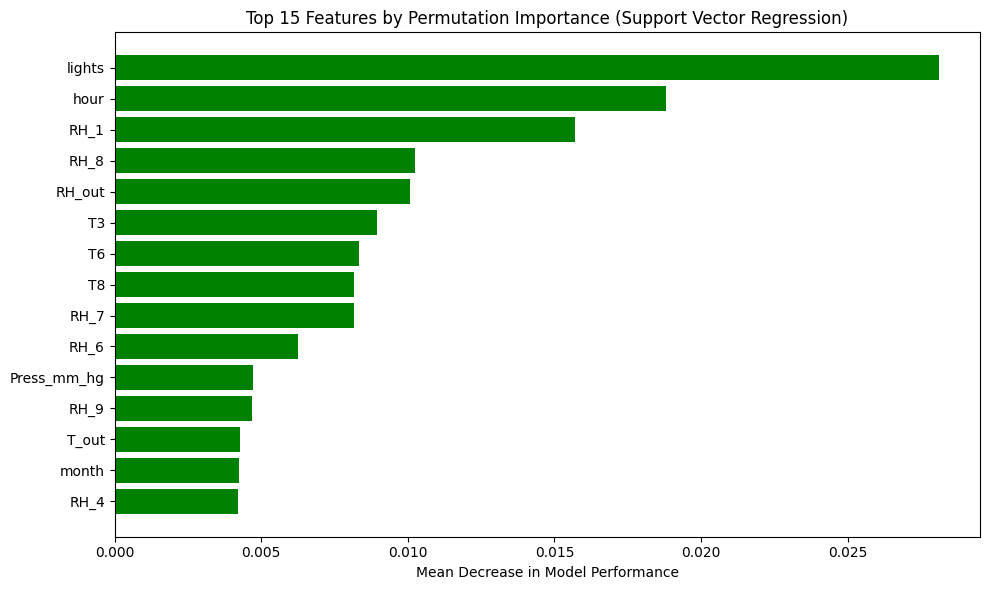

In [27]:
#Support vector regression
from sklearn.svm import SVR
svr_model = SVR(kernel='rbf',gamma='scale')
svr_model.fit(X_train_scaled, y_train)
svr_result = permutation_importance(svr_model, X_test_scaled, y_test, n_repeats=5, random_state=42, n_jobs=-1)
svr_importances = svr_result.importances_mean
svr_indices = np.argsort(svr_importances)[::-1]
svr_features = X.columns[svr_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(15), svr_importances[svr_indices][:15], align='center', color='green')
plt.yticks(range(15), svr_features[:15])
plt.xlabel("Mean Decrease in Model Performance")
plt.title("Top 15 Features by Permutation Importance (Support Vector Regression)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Lastly we will compare the three models against eachother. 

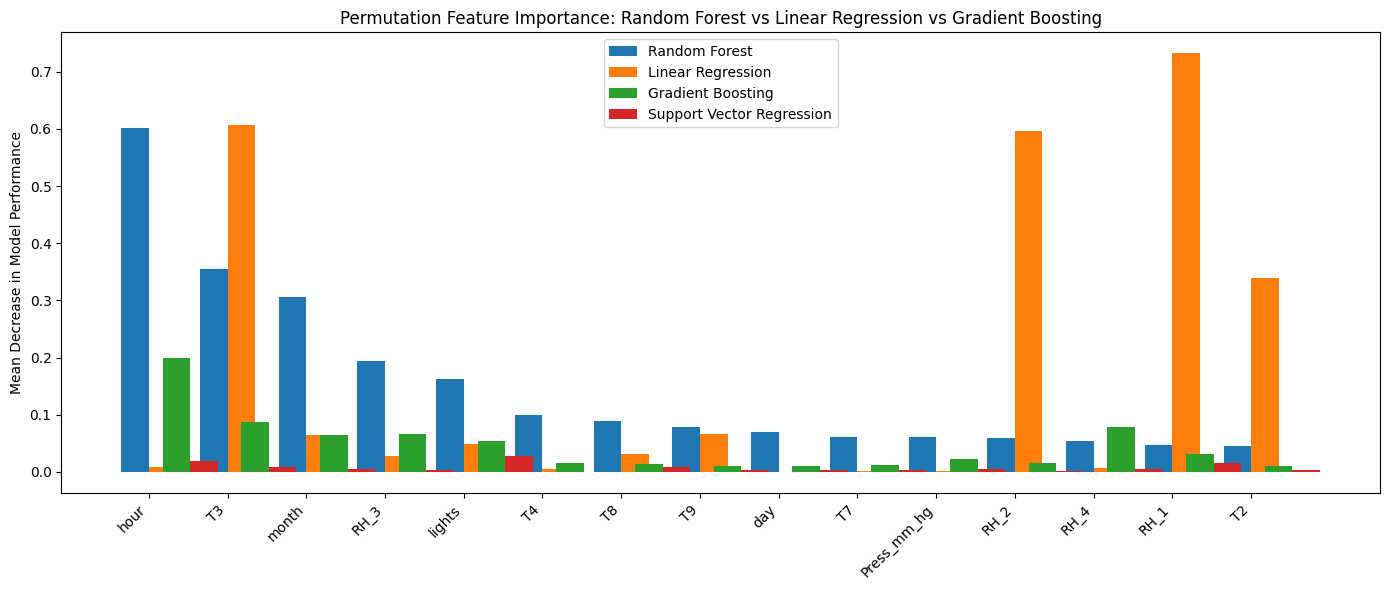

In [28]:
features = X.columns
df_compare = pd.DataFrame({
    'Feature': features,
    'Random Forest': rf_importances,
    'Linear Regression': lr_importances,
    'Gradient Boosting': gb_importances,
    'Support Vector Regression': svr_importances
}).set_index('Feature')

df_compare_sorted = df_compare.sort_values(by='Random Forest', ascending=False)
top_features = df_compare_sorted.head(15)

x = np.arange(len(top_features))
bar_width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - bar_width/2, top_features['Random Forest'], width=bar_width, label='Random Forest')
plt.bar(x + bar_width/2, top_features['Linear Regression'], width=bar_width, label='Linear Regression')
plt.bar(x + bar_width, top_features['Gradient Boosting'], width=bar_width, label='Gradient Boosting')
plt.bar(x + 2*bar_width, top_features['Support Vector Regression'], width=bar_width, label='Support Vector Regression')

plt.xticks(x, top_features.index, rotation=45, ha='right')
plt.ylabel('Mean Decrease in Model Performance')
plt.title('Permutation Feature Importance: Random Forest vs Linear Regression vs Gradient Boosting')
plt.legend()
plt.tight_layout()
plt.show()

This shows us that Random Forest is likely the better model of the three, to use on our dataset. 

It considers more features and gives a more balanced feature importance profile. 

To confirm our results we will compare the R² Score of all models

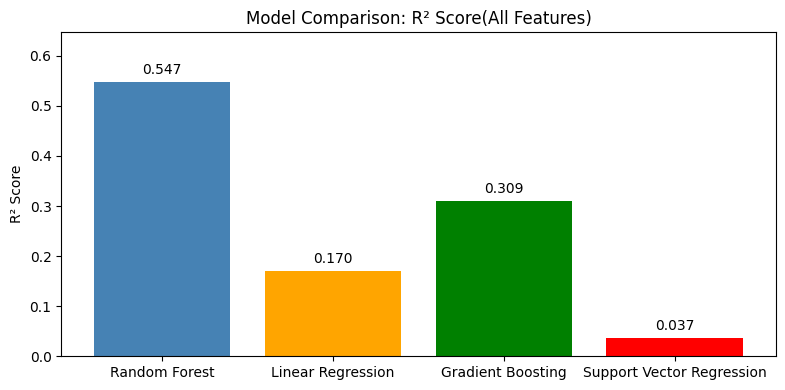

In [29]:
rf_model.fit(X_train_scaled, y_train)
lr_model.fit(X_train_scaled, y_train)
gb_model.fit(X_train_scaled, y_train)
svr_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_svr = svr_model.predict(X_test_scaled)
r2_rf = r2_score(y_test, y_pred_rf)
r2_lr = r2_score(y_test, y_pred_lr)
r2_gb = r2_score(y_test, y_pred_gb)
r2_svr = r2_score(y_test,y_pred_svr)
models = ['Random Forest', 'Linear Regression', 'Gradient Boosting', 'Support Vector Regression']
scores = [r2_rf, r2_lr, r2_gb, r2_svr]

plt.figure(figsize=(8, 4))
bars = plt.bar(models, scores, color=['steelblue', 'orange', 'green','red'])
plt.ylabel('R² Score')
plt.title('Model Comparison: R² Score(All Features)')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.ylim(0, max(scores) + 0.1)
plt.tight_layout()
plt.show()

The Linear Regression model achieved an R² score of 0.170, indicating a weak performance of only 17% variance

In contrast, the Random Forest model achieved a significantly higher R² score of 0.543, indicating a higher performance with 54% variance

Lastly Gradient Boosting has a decent performance of 0.309, indicating 31% of variance

Out of the three models, Random Forrest should be the final choice. It significantly outperforms both Linear Regression and Gradient Boosting in terms of predictive accuracy. The gap shows that non-linear, tree-based models are better suited to this type of energy usage prediction task.

In [61]:
X_top = X[top_features]
X_top_train, X_top_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

scaler_top = StandardScaler()
X_top_train_scaled = scaler_top.fit_transform(X_top_train)
X_top_test_scaled = scaler_top.transform(X_top_test)

rf_top = RandomForestRegressor(n_estimators=50, random_state=42)
lr_top = LinearRegression()
gb_top = GradientBoostingRegressor(n_estimators=100, random_state=42)
svr_top = SVR(kernel='rbf', gamma='scale')  
rf_top.fit(X_top_train_scaled, y_train)
lr_top.fit(X_top_train_scaled, y_train)
gb_top.fit(X_top_train_scaled, y_train)
svr_top.fit(X_top_train_scaled, y_train)


y_pred_rf_top = rf_top.predict(X_top_test_scaled)
y_pred_lr_top = lr_top.predict(X_top_test_scaled)
y_pred_gb_top = gb_top.predict(X_top_test_scaled)
y_pred_svr_top = svr_top.predict(X_top_test_scaled)

r2_rf_top = r2_score(y_test, y_pred_rf_top)
r2_lr_top = r2_score(y_test, y_pred_lr_top)
r2_gb_top = r2_score(y_test, y_pred_gb_top)
r2_svr_top = r2_score(y_test, y_pred_svr_top)

models = ['Random Forest', 'Linear Regression', 'Gradient Boosting','Support Vector Regression']
scores = [r2_rf_top, r2_lr_top, r2_gb_top,r2_svr_top]

plt.figure(figsize=(8, 4))
bars = plt.bar(models, scores, color=['steelblue', 'orange', 'green','red'])
plt.ylabel('R² Score')
plt.title('Model Comparison (Top 15 Features Only)')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.ylim(0, max(scores) + 0.1)
plt.tight_layout()
plt.show()

c:\Users\marca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\marca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\marca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

With top 15 features, Random Forest continues to perform the best even with fewer features. 

Linear Regression again performs the worst likely due to its limited ability to capture complex, non-linear relationships.

Gradient Boosting has also slighty decreased in R2 score compared to when it had more features

Lets make a side-by-side comparison to make it even more clear.

In [40]:
models_extended = [
    'Random Forest (All)', 'Random Forest (Top 15)',
    'Linear Regression (All)', 'Linear Regression (Top 15)',
    'Gradient Boosting (All)', 'Gradient Boosting (Top 15)'
]

scores_combined = [
    r2_all, r2_rf_top,
    r2_lr, r2_lr_top,
    r2_gb, r2_gb_top
]

colors_combined = ['steelblue', 'skyblue', 'orange', 'lightsalmon', 'green', 'lightgreen']

plt.figure(figsize=(10, 5))
bars = plt.bar(models_extended, scores_combined, color=colors_combined)
plt.ylabel('R² Score')
plt.title('R² Comparison: All Features vs Top 15 Features')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.ylim(0, max(scores_combined) + 0.1)
plt.tight_layout()
plt.show()

NameError: name 'r2_all' is not defined

Lastly we will train our model on Random Forrest with top 15 features, all features and then compare the two with an R² comparrison and then a risidual analysis.

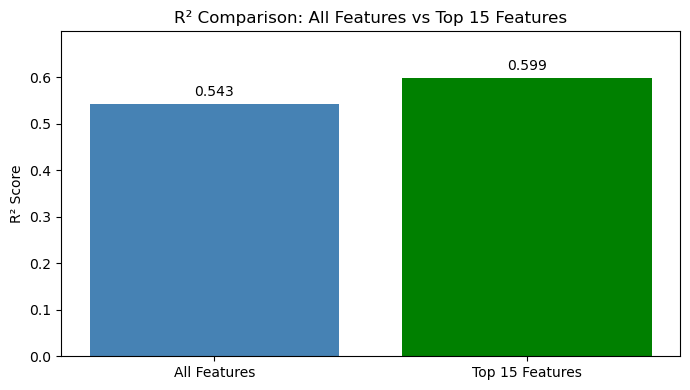

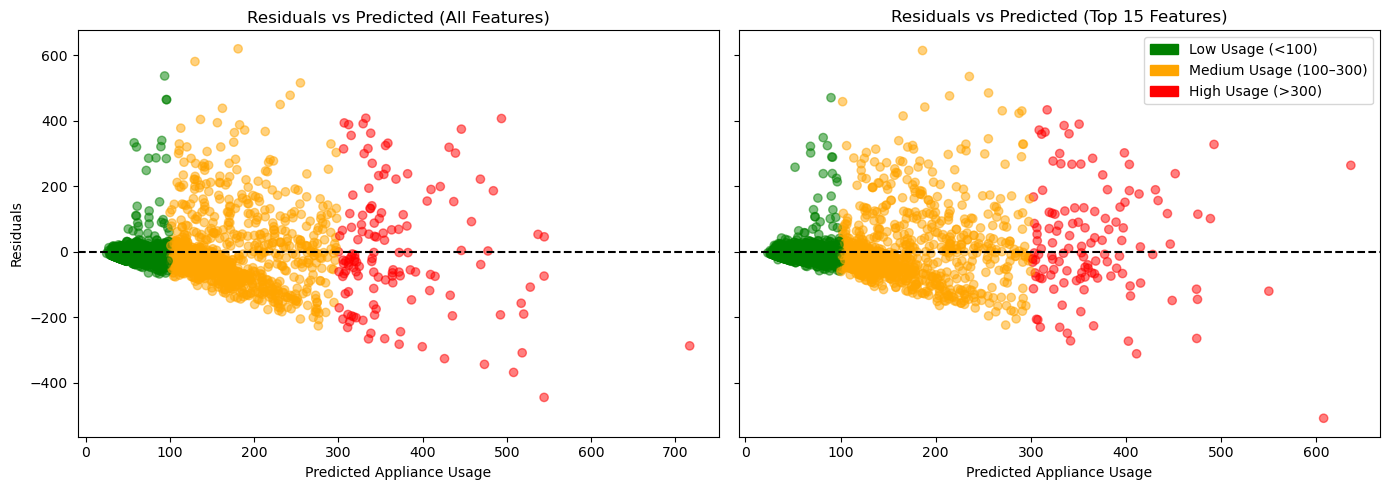

In [63]:
rf_all = RandomForestRegressor(n_estimators=50, random_state=42)
rf_all.fit(X_train_scaled, y_train)
y_pred_all = rf_all.predict(X_test_scaled)
r2_all = r2_score(y_test, y_pred_all)

importances = rf_all.feature_importances_
top_indices = np.argsort(importances)[::-1][:15]
top_features = X.columns[top_indices]

X_top_train = X_train[top_features]
X_top_test = X_test[top_features]

scaler_top = StandardScaler()
X_top_train_scaled = scaler_top.fit_transform(X_top_train)
X_top_test_scaled = scaler_top.transform(X_top_test)

rf_top = RandomForestRegressor(n_estimators=50, random_state=42)
rf_top.fit(X_top_train_scaled, y_train)
y_pred_top = rf_top.predict(X_top_test_scaled)
r2_top = r2_score(y_test, y_pred_top)

models = ['All Features', 'Top 15 Features']
scores = [r2_all, r2_top]

plt.figure(figsize=(7, 4))
bars = plt.bar(models, scores, color=['steelblue', 'green'])
plt.ylabel("R² Score")
plt.title("R² Comparison: All Features vs Top 15 Features")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}", ha='center', va='bottom')

plt.ylim(0, max(scores) + 0.1)
plt.tight_layout()
plt.show()

residuals_all = y_test - y_pred_all

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

colors_all = np.where(y_pred_all < 100, 'green',
              np.where(y_pred_all < 300, 'orange', 'red'))


axes[0].scatter(y_pred_all, residuals_all, alpha=0.5, c=colors_all)
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title("Residuals vs Predicted (All Features)")
axes[0].set_xlabel("Predicted Appliance Usage")
axes[0].set_ylabel("Residuals")

axes[1].scatter(y_pred_top, residuals, alpha=0.5, c=colors)
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title("Residuals vs Predicted (Top 15 Features)")
axes[1].set_xlabel("Predicted Appliance Usage")

green_patch = mpatches.Patch(color='green', label='Low Usage (<100)')
orange_patch = mpatches.Patch(color='orange', label='Medium Usage (100–300)')
red_patch = mpatches.Patch(color='red', label='High Usage (>300)')
axes[1].legend(handles=[green_patch, orange_patch, red_patch])

plt.tight_layout()
plt.show()


As we can see our top 15 feature model not only performs better on R² score, but has more consistent residuals especially in high-usage zones — which is crucial for a real-world energy forecasting models.
Since the RandomForest seems to outperform, let's now try to optimize the hyperparameters. 
First, we have seen that optimizing the number of features not only optimize the computatiional time, but also the accuracy of our regressor. Let's choose the best number of features.


In [68]:


rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
r2_rf = r2_score(y_test, y_pred_rf)
#training r2 score
y_train_pred_rf = rf_model.predict(X_train_scaled)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
print(f"Random Forest R² Score (Test): {r2_rf:.3f}")
print(f"Random Forest R² Score (Train): {r2_train_rf:.3f}")




Random Forest R² Score (Test): 0.543
Random Forest R² Score (Train): 0.931


We first notice that not only we can optimise hyperparameters to enhance our model, but also that this is actually really important since we are in a hard case of overfitting. Using GridSearchCV and therefore cross validation to opitmize will be really useful here.

In [24]:
#Finding the most important features via random forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")


Feature ranking:
1. feature hour (0.1512769277899092)
2. feature T3 (0.05833069545477244)
3. feature RH_3 (0.04338121524872995)
4. feature RH_5 (0.039309285602102624)
5. feature Press_mm_hg (0.03725721800743349)
6. feature T8 (0.03642428534945374)
7. feature RH_2 (0.03481803956138948)
8. feature RH_1 (0.03172570830870008)
9. feature Tdewpoint (0.031558893811641356)
10. feature T2 (0.02940623098216485)
11. feature T4 (0.029282712727305222)
12. feature RH_out (0.029194012814356903)
13. feature RH_8 (0.02906164044322313)
14. feature RH_7 (0.02906015309154984)
15. feature RH_9 (0.0288786603871822)
16. feature RH_4 (0.02869795361381602)
17. feature lights (0.02850847716127394)
18. feature RH_6 (0.027179020798882198)
19. feature T7 (0.027003639151577476)
20. feature T6 (0.026375792682762276)
21. feature T_out (0.02546856011031421)
22. feature Windspeed (0.025364585295211246)
23. feature T1 (0.023481901325475552)
24. feature T5 (0.02279706431814911)
25. feature month (0.021633676826977737)
26

step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done
step done


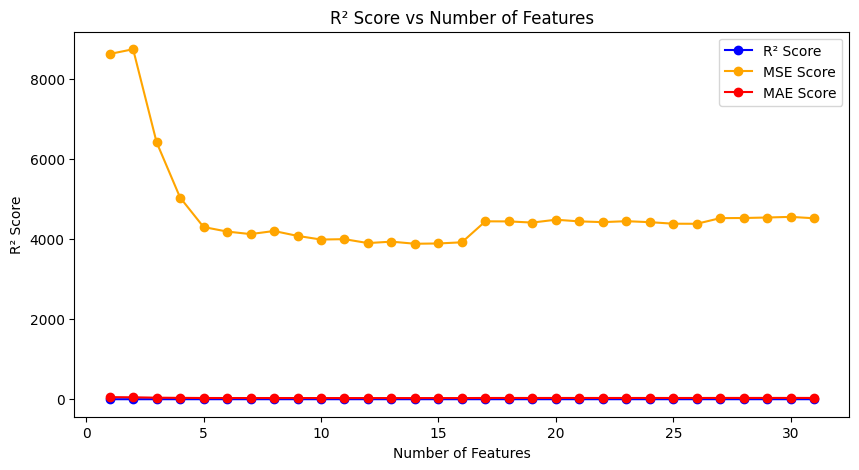

In [26]:
#Print R²,MSE and Mean absolute error for every number of features
r2_scores = []
MSE_scores = []
MAE_scores = []
for i in range(1, X.shape[1] + 1):
    top_features = indices[:i]
    X_train_top = X_train_scaled[:, top_features]
    X_test_top = X_test_scaled[:, top_features]

    rf_model.fit(X_train_top, y_train)
    y_pred = rf_model.predict(X_test_top)
    r2_scores.append(r2_score(y_test, y_pred))
    MSE_scores.append(np.mean((y_test - y_pred) ** 2))
    MAE_scores.append(np.mean(np.abs(y_test - y_pred)))
    print("step done")

# Plot R², MSE and MAE scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, X.shape[1] + 1), r2_scores, marker='o',color='blue', label='R² Score')
plt.plot(range(1, X.shape[1] + 1), MSE_scores, marker='o',color='orange',label='MSE Score')
plt.plot(range(1, X.shape[1] + 1), MAE_scores, marker='o',color='red',label='MAE Score')
plt.legend()
plt.title("R² Score vs Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("R² Score")
plt.show()

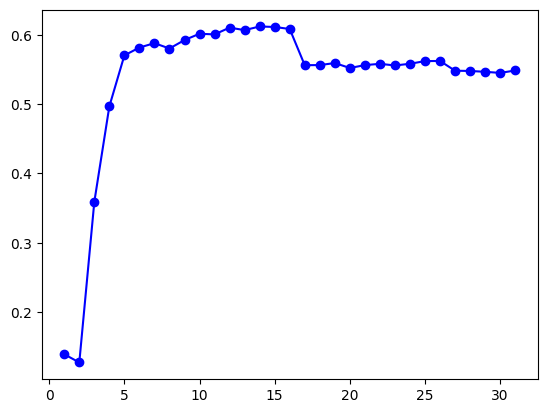

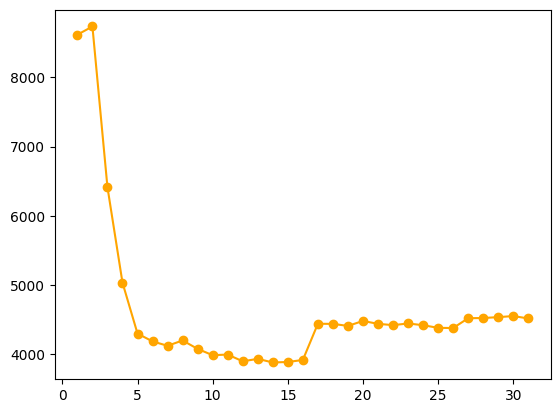

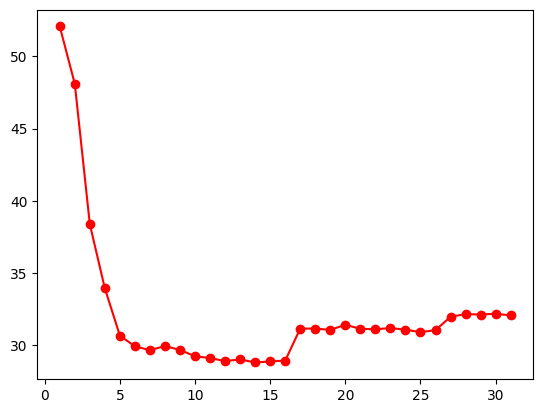

In [32]:
plt.plot(range(1, X.shape[1] + 1), r2_scores, marker='o',color='blue', label='R² Score')
plt.show()
plt.plot(range(1, X.shape[1] + 1), MSE_scores, marker='o',color='orange',label='MSE Score')
plt.show()
plt.plot(range(1, X.shape[1] + 1), MAE_scores, marker='o',color='red',label='MAE Score')
plt.show()

15 features in fact minimizes both the MSE and the MAE while maximising the R^2 score : we found or top numbers of features. Let's, from now on keep only 15 features and optimize the hyperparameters. We will use grid search, and the scoring will be R^2 scores. First let's optimize n_estimators.

In [34]:
#Optimizing n_estimators in random forest with grid search
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150, 200]

}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled[:,indices[:15]], y_train)
best_n_estimators = grid_search.best_params_['n_estimators']
print(f"Best n_estimators: {best_n_estimators}")


Best n_estimators: 200


Now max_depth.

In [35]:
#optimizing max_depth in random forest with grid search
rf_model = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42)
param_grid = {
    'max_depth': [5, 10, 15, 20, None]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled[:,indices[:15]], y_train)
best_max_depth = grid_search.best_params_['max_depth']
print(f"Best max_depth: {best_max_depth}")


Best max_depth: None


Now min_samples_split

In [36]:
#optimizing min_samples_split in random forest with grid search
rf_model = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=42)
param_grid = {
    'min_samples_split': [2, 5, 10, 20]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled[:,indices[:15]], y_train)
best_min_samples_split = grid_search.best_params_['min_samples_split']
print(f"Best min_samples_split: {best_min_samples_split}")



Best min_samples_split: 2


Now min_samples_leaf.

In [37]:
#optimizing min_samples_leaf in random forest with grid search
rf_model = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, min_samples_split=best_min_samples_split, random_state=42)
param_grid = {
    'min_samples_leaf': [1, 2, 4, 10]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled[:,indices[:15]], y_train)
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
print(f"Best min_samples_leaf: {best_min_samples_leaf}")


Best min_samples_leaf: 1


Now max_features.

In [38]:
#optimizing max_features in random forest with grid search
rf_model = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, random_state=42)
param_grid = {
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled[:,indices[:15]], y_train)
best_max_features = grid_search.best_params_['max_features']
print(f"Best max_features: {best_max_features}")


Best max_features: sqrt


Now that we have the best parameters, let's train the best model and compare the metrics with our unoptimized model.

Text(0.5, 1.0, 'R² Comparison: Unoptimized vs Optimized')

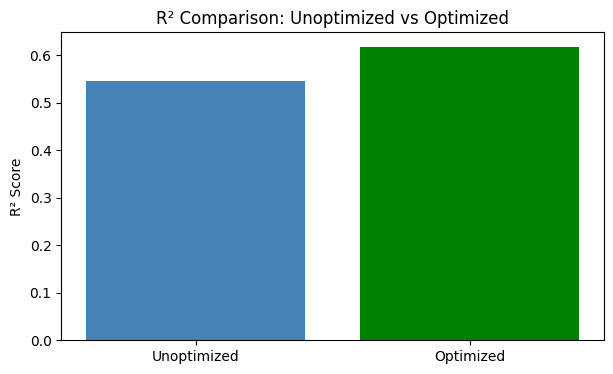

In [42]:
#training the final model with the best parameters
rf_model = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, max_features=best_max_features, random_state=42)

rf_model.fit(X_train_scaled[:,indices[:15]], y_train)
y_pred_final = rf_model.predict(X_test_scaled[:,indices[:15]])
r2_final = r2_score(y_test, y_pred_final)
models = ['Unoptimized', 'Optimized']
scores = [r2_rf, r2_final]

plt.figure(figsize=(7, 4))
bars = plt.bar(models, scores, color=['steelblue', 'green'])
plt.ylabel("R² Score")
plt.title("R² Comparison: Unoptimized vs Optimized")


Let's now try to have a visualization of whether our regression is good. We plot the real appliance of the house on a day (meaned hour by hour) and our predictions.

hour
0      72.000000
1      73.000000
2      51.000000
3      47.000000
4      52.333333
5      47.000000
6      50.000000
7      59.666667
8      61.666667
9      69.333333
10    100.666667
11    105.000000
12    158.000000
13    147.666667
14    139.333333
15     67.666667
16     88.666667
17    214.333333
18    179.333333
19    163.666667
20    159.333333
21    100.666667
22     65.666667
23     54.000000
Name: Appliances, dtype: float64
(720,)


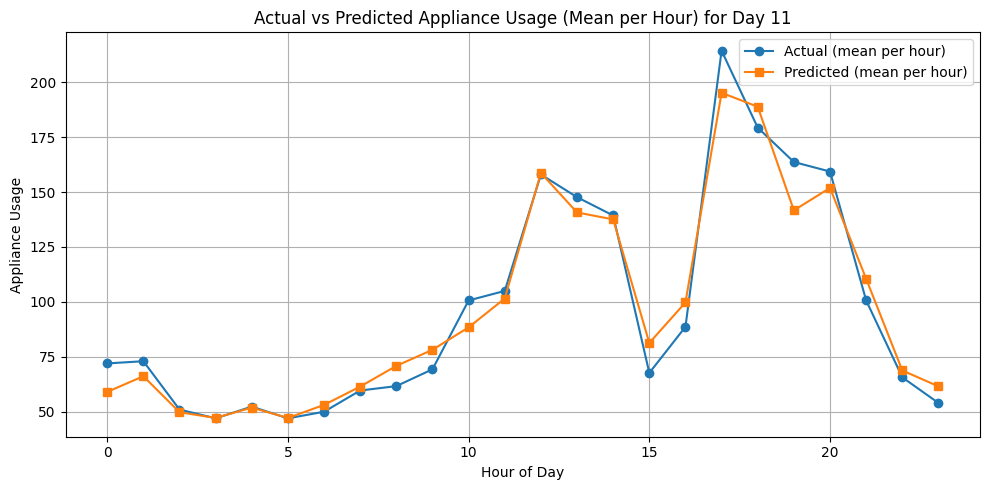

In [60]:
#group our dataset by the day 11 and hours
df_day11 = df[df['day'] == 12].groupby('hour')['Appliances'].mean()
print(df_day11)
#predict the appliances usage for the day 11
X_day11 = df[df['day'] == 12].drop(columns=['Appliances'])
X_day11_scaled = scaler.transform(X_day11)
y_day11_pred = rf_model.predict(X_day11_scaled[:,indices[:15]])
print(y_day11_pred.shape)
# Calculate the mean prediction for each hour (6 values per hour)
hours = df[df['day'] == 12]['hour'].values
unique_hours = np.unique(hours)
y_day11_pred_mean = [y_day11_pred[hours == h].mean() for h in unique_hours]

# Plot actual vs predicted mean appliance usage per hour for day 11
plt.figure(figsize=(10, 5))
plt.plot(df_day11.index, df_day11.values, marker='o', label='Actual (mean per hour)')
plt.plot(unique_hours, y_day11_pred_mean, marker='s', label='Predicted (mean per hour)')
plt.xlabel('Hour of Day')
plt.ylabel('Appliance Usage')
plt.title('Actual vs Predicted Appliance Usage (Mean per Hour) for Day 11')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

We are quite happy about these results :) Not only this shows that our model is well trained, but only that it generalizes well (since here it's no more question of train/test sets). We actually treated the problem of overfitting and enhanced the model.